In [12]:
from __future__ import print_function
import time
import numpy as np
import argparse
import torch

import warnings ; warnings.filterwarnings('ignore') # mute warnings, live dangerously

# import matplotlib.pyplot as plt
# import matplotlib as mpl ; mpl.use("Agg")

from model import IQN
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML

import torchtext
from utils import tokenizer_with_preprocessing
import os
from torchtext.vocab import Vectors
from trainer import Trainer
NEWS_PATH = os.path.join('..', 'data', 'news')

In [13]:
parser = argparse.ArgumentParser(description=None)
parser.add_argument('-e', '--env', default='PongNoFrameskip-v4', type=str, help='gym environment')
parser.add_argument('-d', '--density', default=1, type=int, help='density of grid of gaussian blurs')
parser.add_argument('-r', '--radius', default=5, type=int, help='radius of gaussian blur')
parser.add_argument('-f', '--num_frames', default=100, type=int, help='number of frames in movie')
parser.add_argument('-i', '--first_frame', default=150, type=int, help='index of first frame')
parser.add_argument('-dpi', '--resolution', default=75, type=int, help='resolution (dpi)')
parser.add_argument('-s', '--save_dir', default='./movies/', type=str,
                    help='dir to save agent logs and checkpoints')
parser.add_argument('-p', '--prefix', default='default', type=str, help='prefix to help make video name unique')
parser.add_argument('-c', '--checkpoint', default='*.tar', type=str,
                    help='checkpoint name (in case there is more than one')
parser.add_argument('-o', '--overfit_mode', default=False, type=bool,
                    help='analyze an overfit environment (see paper)')

# text parameter
parser.add_argument('--max_length', type=int, default=64)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--target_update_freq', type=int, default=100)
parser.add_argument('--evaluation_freq', type=int, default=10)
parser.add_argument('--network_save_freq', type=int, default=100)
parser.add_argument('--num_actions', type=int, default=1)

parser.add_argument('--min_freq', type=int, default=10)
parser.add_argument('--embedding_dim', type=int, default=300)
parser.add_argument('--n_filters', type=int, default=50)
parser.add_argument('--filter_sizes', type=list, default=[3, 4, 5])
parser.add_argument('--pad_idx', type=list, default=1)
parser.add_argument('--gamma', type=float, default=0.0)
parser.add_argument('--learning_rate', type=float, default=2.5e-5)
parser.add_argument('--round', type=float, default=0)

parser.add_argument('--num_quantile', type=int, default=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser.add_argument('--device', type=str, default=device)

args = parser.parse_args(args=[])

args.rnn = False

# データを取り出す

In [14]:
# 読み込んだ内容に対して行う処理を定義
TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer_with_preprocessing,
                            use_vocab=True, lower=True, include_lengths=True,
                            batch_first=True, fix_length=args.max_length,
                            init_token="<cls>", eos_token="<eos>")
LABEL = torchtext.data.Field(sequential=False, use_vocab=False, dtype=torch.float)

DATE = torchtext.data.Field(sequential=False)

train_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_train.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
train_ds = train_ds[0]

test_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_test.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
test_ds = test_ds[0]

japanese_fasttext_vectors = Vectors(name='../data/news/cc.ja.300.vec')
TEXT.build_vocab(train_ds,
                 vectors=japanese_fasttext_vectors,
                 min_freq=args.min_freq)
TEXT.vocab.freqs

train_dl = torchtext.data.Iterator(
    train_ds, batch_size=1, train=True)
test_dl = torchtext.data.Iterator(
    test_ds, batch_size=1, train=True, shuffle=False)

In [24]:
for batch in train_dl:
    print(batch.Text1[0])
    break

tensor([[  2,   4,   8, 186,   0,  77, 379, 705, 284,   3,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1]])


# モデルの作成

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vocab_size = len(TEXT.vocab.freqs)
model = IQN(TEXT.vocab.vectors, vocab_size, args.embedding_dim, args.n_filters,
                         args.filter_sizes, args.pad_idx,
                         d_model=300,
                         n_actions=args.num_actions,
                         n_quant=args.num_quantile,
                         rnn=args.rnn)

model = model.to(device)

trainer = Trainer(args, TEXT, train_dl)
trainer.load_model()
trainer.model.eval()

IQN(
  (embedding): Embedding(2638, 300)
  (phi): Linear(in_features=64, out_features=64, bias=True)
  (cnn): CNN(
    (convs): ModuleList(
      (0): Conv2d(1, 50, kernel_size=(3, 300), stride=(1, 1))
      (1): Conv2d(1, 50, kernel_size=(4, 300), stride=(1, 1))
      (2): Conv2d(1, 50, kernel_size=(5, 300), stride=(1, 1))
    )
    (fc0): Linear(in_features=150, out_features=64, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (rnn): RNN(
    (lstm): LSTM(300, 50, batch_first=True, bidirectional=True)
    (attn): Attn(
      (fc): Sequential(
        (0): Linear(in_features=50, out_features=24, bias=True)
        (1): ReLU(inplace=True)
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=24, out_features=1, bias=True)
      )
    )
    (fc0): Linear(in_features=50, out_features=64, bias=True)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc_q): Linear(in_features=64, o

# rolloutの作成

In [6]:
# HTMLを作成する関数を実装
def highlight(word, attn):
    "Attentionの値が大きいと文字の背景が濃い赤になるhtmlを出力させる関数"

    if attn >= 0:
        html_color = '#%02X%02X%02X' % (
            255, int(255*(1 - attn)), int(255*(1 - attn)))
    else:
        html_color = '#%02X%02X%02X' % (
            int(255*(1 - attn)), 255, int(255*(1 - attn)))
    return '<span style="background-color: {}"> {}</span>'.format(html_color, word)

def mk_html(sentence, attens):

    # 表示用のHTMLを作成する
#     html = '正解ラベル：{}<br>推論ラベル：{}<br><br>'.format(reward, pred)
    html = ""
    # 1段目のAttention
    html += '<br>'
    for word, attn in zip(sentence, attens):
        word = TEXT.vocab.itos[word]
        if word[0] == '<':
            word = word[1:-1]
            if (word == 'pad') or (word=='unk'):
                continue
        html += highlight(word, attn)
    html += "<br><br>"

    return html

def blur_func(I, mask):
    return I * mask #+ I * mask#+ gaussian_filter(I, sigma=3) * mask

In [22]:
eta0 = 0
eta1 = 1
std_list = []
for batch in test_dl:
    with torch.no_grad():
        state = batch.Text1[0].to(device)
        curr_q, _, _ = trainer.model(state, eta0, eta1, True)
    std = curr_q.view(-1).std().cpu().detach().item()
    std_list.append(std)
    if std > 19:
        state = state.view(-1).cpu().numpy()
        for word in state:
            vocab = TEXT.vocab.itos[word]
            if (vocab == '<pad>') or (vocab == '<unk>'):
                continue
            print(vocab+' ', end='')
        print()

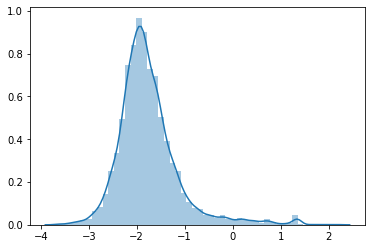

In [23]:
sns.distplot(np.log(std_list))

In [24]:
std_list = []
for i, batch in enumerate(test_dl):
    with torch.no_grad():
        state = batch.Text1[0].to(device)
        curr_q, _, _ = trainer.model(state, eta0, eta1, True)
    std = curr_q.view(-1).std().cpu().detach().item()
    std_list.append(std)
    if np.log(std) > 1:
        print('i = ', i)
        state = state.view(-1).cpu().numpy()
        for word in state:
            vocab = TEXT.vocab.itos[word]
            if (vocab == '<pad>') :
                continue
            print(vocab+' ', end='')
        print()

i =  6
<cls> <company> <location> <unk> 専門店 <eos> 
i =  163
<cls> <company> <unk> <unk> <unk> ヨーカ堂 <unk> <eos> 
i =  206
<cls> そごう・西武 西武池袋本店 外国人 富裕層 <unk> <eos> 
i =  257
<cls> <location> <location> <unk> <unk> <company> <eos> 
i =  340
<cls> <company> 小安い 塩ビ <location> <unk> <eos> 
i =  351
<cls> 00 ﾙｰﾙ 報告 0日 <company> 0 保有 割合 増 ﾌﾞﾗｯｸﾛｯｸ ｼﾞｬﾊﾟﾝ 株式会社 <eos> 
i =  358
<cls> <company> 小高い <location> 目標株価 引き上げ <eos> 
i =  573
<cls> <company> <unk> <unk> <unk> ワクチン <unk> <span> 00 ﾙｰﾙ 報告 0日 <company> 0 その他 変更 株式会社 三菱ufj ﾌｨﾅﾝｼｬﾙ ｸﾞﾙｰﾌﾟ <eos> 
i =  646
<cls> <company> がん 創薬 <location> ベンチャー 共同研究 <eos> 
i =  740
<cls> <company> <unk> <unk> <unk> <unk> <eos> 
i =  760
<cls> <unk> <unk> <unk> <company> <unk> <eos> 
i =  783
<cls> <company> <unk> <unk> <unk> <unk> <unk> <eos> 
i =  1365
<cls> <company> <unk> <unk> <unk> <unk> <unk> <eos> 
i =  1368
<cls> 株価 格付 ｺﾞｰﾙﾄﾞﾏﾝ ｻｯｸｽ 証 ﾌｧﾅｯｸ 0 買い 推奨 0日 <eos> 
i =  2226
<cls> <company> <unk> <unk> <unk> 監視カメラ <eos> 
i =  2242
<cls> <company> <unk> <unk> <un

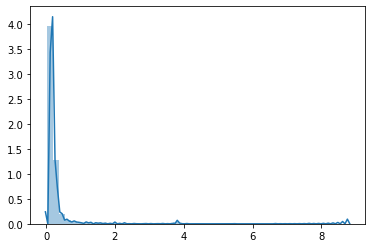

In [25]:
sns.distplot(std_list)

In [26]:
states = []
rewards = []
for batch in test_dl:
    states.append(batch.Text1[0].numpy()[0])
    rewards.append(batch.Label.numpy()[0])

states = np.array(states)
rewards = np.array(rewards)

reward:  7.115629 mean:  5.3025503 median:  5.287678 std:  0.1818766 sr:  29.15466


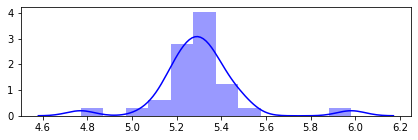

In [33]:
idx = 1339
eta0 = 0
eta1 = 1

sentence = states[idx]
state = torch.LongTensor(sentence).to(device).unsqueeze(0)

# 1次元maskの作成
mask = np.zeros((1*args.max_length, args.max_length)).astype(np.int8)

for j in range(args.max_length):
    circle = np.ones([args.max_length])
    if (sentence[j] == 0) or (sentence[j] == 1) \
            or (sentence[j] == 2) or (sentence[j] == 3):
        circle[j] = 1
    else:
        circle[j] = 0
    mask[j] = circle.astype(np.int8)

# ネットワークの出力を得る
with torch.no_grad():
    curr_q, _, _ = trainer.model(state, eta0, eta1, True)
    L = curr_q.mean()

# 各ピクセルにマスクする
masked_sentence = blur_func(sentence, mask)

# ノイズを入れたデータの出力を得る
state = torch.LongTensor(masked_sentence).to(device)
state = state.view(-1, args.max_length)
with torch.no_grad():
    masked_curr_q, _, _ = trainer.model(state, eta0, eta1, True)
    l = masked_curr_q.mean(axis=1)

pad_mask = np.ones([args.max_length])
for j in range(args.max_length):
    if (sentence[j] == 0) or (sentence[j] == 1) \
            or (sentence[j] == 2) or (sentence[j] == 3):
        pad_mask[j] = 0

# スコアを記憶する配列
scores = np.zeros(args.max_length)   # saliency scores S(t,i,j)

for j in range(0, args.max_length):
    # d=5としてその部分を描画する
    scores[j] = (L-l[j]).pow(2).sum().mul_(.5).item()
#     scores[j] = (L-l[j]).sum().item()

scores = scores * pad_mask
saliency = scores / (np.abs(scores).max() + 1e-20)

# S = saliency.copy()
# pmax = S.max()

# S -= S.min()
# S = pmax * S / S.max()

fig, ax = plt.subplots(1, figsize=(7, 2));
sns.distplot(curr_q.view(-1).cpu().numpy(), color='blue', ax=ax)

print('reward: ', rewards[idx], 
          'mean: ', np.mean(curr_q.view(-1).cpu().numpy()),
          'median: ', np.median(curr_q.view(-1).cpu().numpy()),
          'std: ', np.std(curr_q.view(-1).cpu().numpy()),
          'sr: ', np.mean(curr_q.view(-1).cpu().numpy()) / np.std(curr_q.view(-1).cpu().numpy()))

html_output = mk_html(states[idx], saliency)
HTML(html_output)

In [ ]:
saliency